In [2]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
folder1 = '/kaggle/input/preprocessed-ct-scans-for-covid19/Original CT Scans/nCT'
folder2 = '/kaggle/input/preprocessed-ct-scans-for-covid19/Original CT Scans/pCT'
positive = []
negative = []
for filename in os.listdir(folder2):
    img_path = os.path.join(folder2, filename)
    img = cv.imread(img_path)
    img = cv.resize(img, (512, 512), interpolation = cv.INTER_CUBIC)
    img = np.array(img,dtype='float64')
    img/=np.max(img)
    positive.append(img)
for filename in os.listdir(folder1):
    img_path = os.path.join(folder1, filename)
    img = cv.imread(img_path)
    img = cv.resize(img, (512, 512), interpolation = cv.INTER_CUBIC)
    img = np.array(img,dtype='float64')
    img/=np.max(img)
    negative.append(img)
positive = np.array(positive)
negative = np.array(negative)

# Model architecture

In [4]:
def unet_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    b1 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    
    # Decoder
    u1 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b1)
    u1 = layers.concatenate([u1, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    
    u2 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    
    u3 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    
    u4 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
    return Model(inputs, outputs)

unet = unet_model()
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_11[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_13[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_15[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │  4,719,104 │ conv2d_17[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  4,719,104 │ concatenate_1[0]

 Total params: 21,939,585 (83.69 MB)

 Trainable params: 21,939,585 (83.69 MB)

 Non-trainable params: 0 (0.00 B)

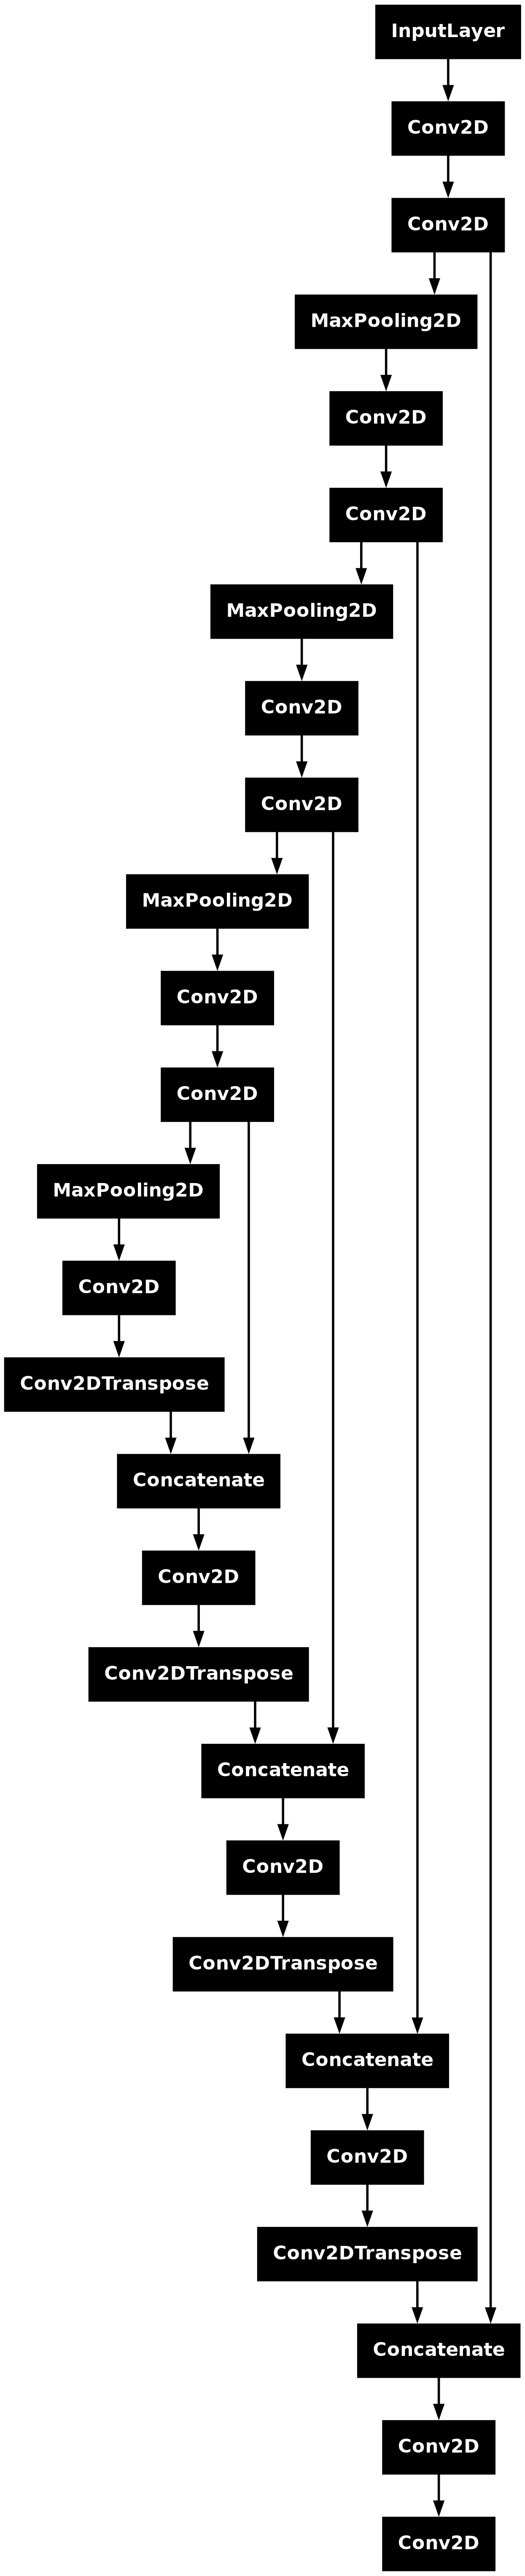

In [6]:
tf.keras.utils.plot_model(unet)

In [10]:
def get_noise_schedule(num_steps=1000):
    betas = np.linspace(1e-4, 0.02, num_steps)
    alphas = 1.0 - betas
    alpha_prod = np.cumprod(alphas)
    return alpha_prod, betas
a,b = get_noise_schedule()
print(a.shape,b.shape)

(1000,) (1000,)
